# Lab 3
## Motion Capture Clustering

### Team members: Luay Dajani, Dana Geislinger, Chris Morgan, Caroll Rodriguez
##### Github - https://github.com/cdmorgan103/7331DataMiningNoShow

MSDS 7331, 12/02/2018

### Business Understanding 1
#### 10pts
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific
dataset and the stakeholders needs?


https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures#

A Vicon motion capture camera system was used to record 12 users performing 5 hand postures with markers attached to a left-handed glove. 

A rigid pattern of markers on the back of the glove was used to establish a local coordinate system for the hand, and 11 other markers were attached to the thumb and fingers of the glove. 3 markers were attached to the thumb with one above the thumbnail and the other two on the knuckles. 2 markers were attached to each finger with one above the fingernail and the other on the joint between the proximal and middle phalanx. 

The 11 markers not part of the rigid pattern were unlabeled; their positions were not explicitly tracked. Consequently, there is no a priori correspondence between the markers of two given records. In addition, due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers. Extraneous markers were also possible due to artifacts in the Vicon software's marker reconstruction/recording process and other objects in the capture volume. As a result, the number of visible markers in a record varied considerably. 

The data presented here is already partially preprocessed. First, all markers were transformed to the local coordinate system of the record containing them. Second, each transformed marker with a norm greater than 200 millimeters was pruned. Finally, any record that contained fewer than 3 markers was removed. The processed data has at most 12 markers per record and at least 3. For more information, see 'Attribute Information'. 

Due to the manner in which data was captured, it is likely that for a given record and user there exists a near duplicate record originating from the same user. We recommend therefore to evaluate classification algorithms on a leave-one-user-out basis wherein each user is iteratively left out from training and used as a test set. One then tests the generalization of the algorithm to new users. A 'User' attribute is provided to accomodate this strategy. 

This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classification. One may also attempt user identification. Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures. 

##### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system. 

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 
'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier. 
'Xi' - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 
'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 
'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11. 

Each record is a set. The i-th marker of a given record does not necessarily correspond to the i-th marker of a different record. One may randomly permute the visible (i.e. not missing) markers of a given record without changing the set that the record represents. For the sake of convenience, all visible markers of a given record are given a lower index than any missing marker. A class is not guaranteed to have even a single record with all markers visible. 


### Data Understanding 1
#### 10pts
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
from matplotlib import style
from pprint import pprint
#from IPython.display import display

pd.set_option("display.max_columns",100)

# Load the data into variable 'df'
df = pd.read_csv('https://raw.githubusercontent.com/cdmorgan103/7331DataMiningNoShow/master/LAB3/Postures.csv')

# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78096 entries, 0 to 78095
Data columns (total 38 columns):
Class    78096 non-null int64
User     78096 non-null int64
X0       78096 non-null float64
Y0       78096 non-null float64
Z0       78096 non-null float64
X1       78096 non-null float64
Y1       78096 non-null float64
Z1       78096 non-null float64
X2       78096 non-null float64
Y2       78096 non-null float64
Z2       78096 non-null float64
X3       78096 non-null object
Y3       78096 non-null object
Z3       78096 non-null object
X4       78096 non-null object
Y4       78096 non-null object
Z4       78096 non-null object
X5       78096 non-null object
Y5       78096 non-null object
Z5       78096 non-null object
X6       78096 non-null object
Y6       78096 non-null object
Z6       78096 non-null object
X7       78096 non-null object
Y7       78096 non-null object
Z7       78096 non-null object
X8       78096 non-null object
Y8       78096 non-null object
Z8       78096 n

In [2]:
# we will remove class 0 
df = df[df.Class !=0 ]

#change ? to none to improve data format
df=df.replace({'?': 'NaN'})

#coerces into numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [3]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.232264,67.749220,-73.684130,59.188576,10.678936,-71.297781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.450873,68.400808,-70.703991,61.587452,11.779919,-68.827418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.835388,68.907925,-71.138344,61.686427,11.793440,-68.889316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.596157,11.250648,-68.956425,77.387225,42.717833,-72.015146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.368748,67.901260,-72.444650,61.275402,10.841109,-69.279906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Get an overview of the raw data
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78095 entries, 1 to 78095
Data columns (total 38 columns):
Class    78095 non-null int64
User     78095 non-null int64
X0       78095 non-null float64
Y0       78095 non-null float64
Z0       78095 non-null float64
X1       78095 non-null float64
Y1       78095 non-null float64
Z1       78095 non-null float64
X2       78095 non-null float64
Y2       78095 non-null float64
Z2       78095 non-null float64
X3       77405 non-null float64
Y3       77405 non-null float64
Z3       77405 non-null float64
X4       74975 non-null float64
Y4       74975 non-null float64
Z4       74975 non-null float64
X5       65072 non-null float64
Y5       65072 non-null float64
Z5       65072 non-null float64
X6       52247 non-null float64
Y6       52247 non-null float64
Z6       52247 non-null float64
X7       38943 non-null float64
Y7       38943 non-null float64
Z7       38943 non-null float64
X8       30563 non-null float64
Y8       30563 non-null float64

Only 31 data points appear for the 11th sensor, and are for one user. We will delete this as a feature as it does not provide any value.

In [5]:
del df['X11']
del df['Y11']
del df['Z11']

#### Reformatting the Data for Sensor Clustering

The raw data for this dataset is formatted with each capture being treated as a separate observation. This makes sense if you are classifying the gesture or user, but we are trying to cluster in order to identify which sensor on the glove corresponds to a specific set of coordinates. Therefore, we must stack the data in order to get a new dataset where each observation has only a single X, Y, and Z coordinate, and corresponds to the specific position of an individual sensor module in any given capture. 

The original dataset consists of 78,095 captures with coordinates on up to 11 sensors in any given capture, as well as metadata pertaining to the capture about the user and class the capture was representative of. We will retain this metadata, and also create a new variable that corresponds to the sensor number (0 through 10). However, each coordinate will now be labelled as the raw coordinate number on each cartesian axis (X, Y, Z) regardless of sensor number (as opposed to X0, Y10, Z5, etc. as was the case originally).

At this point, we will now also drop missing datapoints; NaN values in this dataset represent sensors that were obscured or not recorded for some other reason during a capture, and since we are interested in clustering by sensor, it does not further the analysis to include sensor coordinates for which no data was recorded.

In [6]:
# Create a list of dataframes with X, Y, Z coordinates selected for each individual sensor (0-10)
df_coords = [df.loc[:, ['Class', 'User', 'X%d' % i, 'Y%d' %i, 'Z%d' % i]] for i in range(11)]

for i in range(len(df_coords)):
    # NaN values are dropped at this time
    df_coords[i] = df_coords[i].dropna()
    
    # Coordinate variable labels will now be standardized
    df_coords[i].columns = ['Class', 'User', 'X', 'Y', 'Z']
    
    # Sensor number will now be added as a variable 'sensor' to each dataset
    df_coords[i]['Sensor'] = i
    
# Combine datasets into new dataframe: df2
df2 = pd.concat(df_coords, ignore_index=True)

# Reorder columns with metadata columns first
df2 = df2[['Class', 'User', 'Sensor', 'X', 'Y', 'Z']]

With the newly formatted dataset, we now have 612,209 distinct cartesian coordinates with corresponding Sensor, Class, and User metadata.

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612209 entries, 0 to 612208
Data columns (total 6 columns):
Class     612209 non-null int64
User      612209 non-null int64
Sensor    612209 non-null int64
X         612209 non-null float64
Y         612209 non-null float64
Z         612209 non-null float64
dtypes: float64(3), int64(3)
memory usage: 28.0 MB


### Data Understanding 2
#### 10pts
Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

##### Number of Datapoints per User by Class (Hand Gesture)

In [8]:
import pandas as pd
# Print descriptive info for the unique values for each predictor

#1=Fist(with thumb out), 
#2=Stop(hand flat), 
#3=Point1(point with pointer finger), 
#4=Point2(point with pointer and middle fingers), 
#5=Grab(fingers curled as if to grab). 

print('Class:', list(df2.Class.unique()))
print('User:', list(df2.User.unique()))
#df_User = df.groupby(['User','Class'])['Class'].count() 
df_Class = df2.groupby(['Class', 'User'])['User'].count()

df_Class['total'] = sum(df_Class) #df_User 

df_Class

Class: [1, 2, 3, 4, 5]
User: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Class  User
1      0         8998
       1         6369
       2         5987
       4          114
       5         4604
       6         5016
       7          432
       8         6450
       9         4560
       10       15045
       11        9581
       12        4183
       13       11882
       14        7394
2      0        16425
       1         8184
       2         8876
       4          597
       5        10841
       6        10582
       7         1016
       8        15242
       9         9201
       10       16291
       11       14372
       12       10322
       13       16177
       14       19672
3      0         9782
       1         5391
                ...  
       12        6240
       13        7797
       14       15857
4      0        11786
       1         4754
       2         4738
       4          965
       5         8204
       6         6168
       7         1033
       8         8603
       9         7495
       10       13461
       11       1400

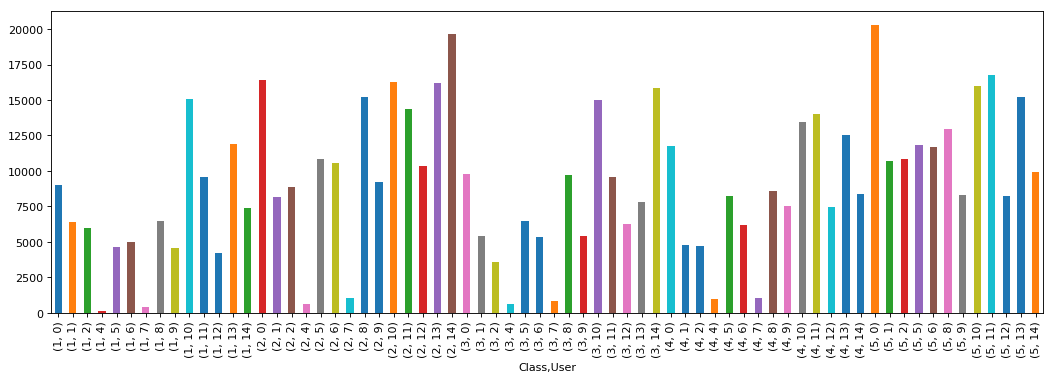

In [9]:
del df_Class['total']
#plot and format bar chart
plt.figure(figsize=(16,5), dpi=80)
_ = df_Class.plot(kind='bar')
#plt.barh(df_neighborhood, width=0.4, height=0.4, align='center', alpha=0.4)

### Percentage of datapoints for each User by Class (Hand Gesture)

In [10]:
byClass = df2.groupby(['Class'])['User'].count()
User_byClass = df2.groupby(['Class','User'])['User'].count()

output = User_byClass['Percentage'] = (User_byClass / byClass ) * 100

df_output = output.to_frame("Percentage")
df_output

Percentage
Class User            
1     0       9.929923
      1       7.028638
      2       6.607074
      4       0.125807
      5       5.080837
      6       5.535507
      7       0.476742
      8       7.118027
      9       5.032279
      10     16.603211
      11     10.573305
      12      4.616234
      13     13.112619
      14      8.159797
2     0      10.408877
      1       5.186378
      2       5.624913
      4       0.378332
      5       6.870176
      6       6.706042
      7       0.643861
      8       9.659185
      9       5.830872
      10     10.323958
      11      9.107847
      12      6.541274
      13     10.251714
      14     12.466571
3     0       9.633642
      1       5.309238
...                ...
      11      9.407130
      12      6.145361
      13      7.678747
      14     15.616506
4     0      10.754336
      1       4.337868
      2       4.323269
      4       0.880531
      5       7.485880
      6       5.628097
      7       0.942578
      8       7.849954
      9       6.838940
      10     12.282719
      11     12.774539
      12      6.835291
      13     11.425000
      14      7.640999
5     0      13.280232
      1       7.030518
      2       7.078336
      5       7.741889
      6       7.665250
      8       8.505008
      9       5.440087
      10     10.480601
      11     10.961399
      12      5.374583
      13      9.941505
      14      6.500593

[68 rows x 1 columns]

### Interactive Plotting of User/Class Combinations

In [11]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
import pandas as pd
import numpy as np

# Set up plotly API key
plotly.tools.set_credentials_file(username='danageis', api_key='0NAcrzM8YksRAT3uyEZ7')

# Enable offline plots (embed into ipynb)
init_notebook_mode(connected=True)

# Define list of possible users
possible_users = set(df.User.unique())

# Define dictionary of all possible user/class combinations (which ones took pictures of which)
possible_classes = {usr: set(df.where(df.User == usr).Class.dropna().unique()) for usr in possible_users}

# Define functions to create 3D-interactive plots of each user/position combo
def parse_coords(cls=1, usr=1):
    """ Helper function: return all coords for specified User and Class
    
    cls (int): Class (defaults to 1)
    usr (int): User (defaults to 1)
    
    Ret (dict): {dimension (str): coordinates (pd.Series)}
    """
    dims = ['X', 'Y', 'Z']
    fill = lambda suffix: [suffix + str(i) for i in range(1,11)]
    cols = {col: fill(col) for col in dims}
    coords = {dim: df[cols[dim]].where(df.User == usr).where(df.Class == cls).stack() for dim in dims}
    return coords

def plot_3d(cls=1, usr=1, title=None, allpts=False, clusters=np.array([0])):
    """ Return 3D interactive plot for given coordinates set (single user/sign combos)
    
    cls (int): Class (defaults to 1)
    usr (int): User (defaults to 1)
    title (str): Title of the plot (defaults to "User {usr} Position {cls}")
    allpts (bool): Whether or not this is meant to cluster all points in the dataset (df2)
        All 600k+ points is too many to plot interactively; this will sample 20,000 points randomly and graph them
    clusters (np.array): Clusters to use for color-coding (only valid for allpts at this time)
    
    Ret (plotly.graph_objs.Scatter3d figure object)
    """
    
    # Make sure user/class designation is valid
    if not usr in possible_users:
        return "ERROR: User %d does not have any data. Try again with a different user specified." % usr
    elif not cls in possible_classes[usr]:
        return "ERROR: User %d does not have any data for Class %d. Try again with a different class specified." % (usr, cls)
    
    # Process points to draw
    if allpts:
        # Sample 20,000 random coords w/o replacement
        coords = df2.copy()
        if clusters.any():
            coords['cluster'] = clusters
        coords = coords.sample(n=20000, replace=False)
    else:
        coords = parse_coords(cls, usr)
        
    # Name plot if title not provided (default behavior)
    if not title:
        if allpts:
            title = "20,000 Random Points from Dataset"
            if clusters.any():
                title += " (Clustered)"
        else:
            title = "User %d Position %d" % (usr, cls)

    # Color-code clustered points, if provided
    if allpts and clusters.any():
        marker_params = dict(size=5,
                             color=coords.cluster,
                             colorscale='Portland'
                             )
    else:
        marker_params = dict(size=5)
            
    data = [go.Scatter3d(x=coords['X'],
                         y=coords['Y'],
                         z=coords['Z'],
                         mode='markers',
                         marker=marker_params
                         )
            ]

    layout = dict(width=800,
                  height=700,
                  autosize=True,
                  title=title,
                  scene=dict(xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             zaxis=dict(gridcolor='rgb(255, 255, 255)',
                                        zerolinecolor='rgb(255, 255, 255)',
                                        showbackground=True,
                                        backgroundcolor='rgb(230, 230,230)'
                                        ),
                             camera=dict(up=dict(x=0,
                                                 y=0,
                                                 z=1
                                                 ),
                                         eye=dict(x=-1.7428,
                                                  y=1.0707,
                                                  z=0.7100,
                                                  )
                                         ),
                             aspectratio = dict(x=1,
                                                y=1,
                                                z=0.7
                                                ),
                             aspectmode = 'manual'
                             ),
                )

    fig = dict(data=data, layout=layout)

    return py.iplot(fig, filename="Hands-%s" % title)

In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
plot_3d(cls=1, usr=1)

### Modeling and Evaluation 1
#### 10 pts
Train and adjust parameters

For this data, we will be attempting to cluster the data on the basis of the sensors used to collect the data. As described in the business understanding section, this dataset consists of snapshot measurements taken from a special glove fitted with sensors to track a person's hand movements and map them to 3-dimensional space. The dataset has recorded data for up to 11 sensors in each capture (some may have been obscured when measurement was performed), and associated 3D coordinates for each sensor. Captures were taken for 13 users who were performing one of five pre-defined gestures with their hand.

Our goal is to cluster each data point based on which of the 11 possible sensors it corresponds to. Each record in the dataset has been formatted so that it represents a single coordinate location for an individual sensor. To accomplish this we will attempt clustering with 11 total clusters defined in our clustering algorithms, ideally corresponding with each of the sensors that is present on the glove. We will begin by performing cluster analysis of all points aggregated together:

In [14]:
plot_3d(allpts=True)

In [15]:
plot_3d(allpts=True)

Shown above are 2 random samplings of 20,000 points each from the dataset. This was done to illustrate that when multiple random samples are plotted in 3-dimensional space, the distributions are different each time but there are similar patterns that can be observed consistently such as 2 large elliptoid clusters on the right side and some smaller clusters on the left side. This provides some anecdotal evidence that clustering may be successful using all available data aggregated from every user and every gesture class.

### GMM Clustering

Visualizing the data set as we have in the two random samples above, it seems that while there are some obvious discrete clusters in 3-dimensional space these clusters are not necessarily uniform globular clusters. These type of clusters might be well defined using Gaussian mixture model clustering which would allow for normally distributed clusters of varying shapes and sizes. We will first attempt to fit a Gaussian mixture model to obtain clusters for the 11 sensors in the dataset.

In [16]:
from sklearn.mixture import GaussianMixture as GMM

# Fit 11 clusters
#  Set random state to '123456789' to make sure same result achieved each time
gmm = GMM(n_components=11,
          random_state=123456789
          )
gmm_X = df2[['X','Y','Z']]
gmm.fit(gmm_X)
gmm_clusters = gmm.predict(gmm_X)

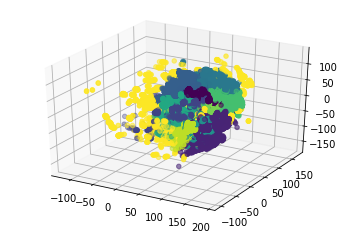

In [17]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = gmm_X['Z'].astype(float)
xdata = gmm_X['X'].astype(float)
ydata = gmm_X['Y'].astype(float)
_ = ax.scatter3D(gmm_X['X'], gmm_X['Y'], gmm_X['Z'], c=gmm_clusters)

In [18]:
plot_3d(allpts=True, clusters=gmm_clusters)

We plot the basic GMM clusters above, both as a static image consisting of all points (more than 600,000) and an interactive plot that is sampled as 20,000 random points from the dataset color-coded by cluster. From these visuals, we can see that there does appear to be decent clustering.

From the data description, we know that there are 2 sensors on each finger and 3 sensors on the thumb. We also know that there are several positions in which multiple (sometimes more than half) of the sensors are obscured from view and not recorded. Therefore, this clustering makes sense from a logical perspective, but it could likely still be improved.

Another interesting comparison is the distribution of clusters as defined by GMM. While we do not know from the raw data which sensors correspond to which point on the glove, we do know that in a majority of recorded instances there are sensors that were unable to be recorded. It would be interesting to note if this clustering algorithm created clusters of varying sizes, which might be indicative of an uneven distribution of which sensors were not recorded most or least often.

It is interesting to note from this distribution that there are significantly varying distributions between clusters. If these clusters do in fact coincide with sensors on the glove, this could provide evidence that certain sensors appear more often than others.

This also makes logical sense, since it would be expected that some of the gestures being performed would have obscured at least part of the hand. The distribution shows that from GMM, there are 2 clusters defined that are very scarce in the total (both less than 5%) compared to the rest. This could be accounted for as the 2 sensors present on a finger that is often obscured, such as the pinky finger. Conversely, there are 2 clusters that stand out as about the same percentage as eachother (almost 14%) but both significantly higher than most of the other clusters. These cluster could represent sensors on fingers that are needed to perform most of the gestures recorded, so they might show up regardless of user or class.

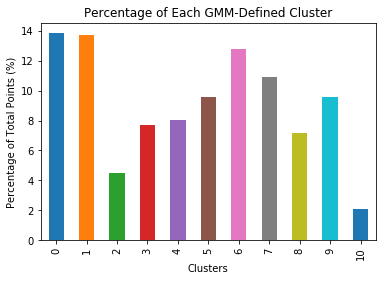

In [19]:
# Create a new dataframe with the clusters defined as a new variable
df_gmm = gmm_X.copy()
df_gmm['Clusters'] = gmm_clusters

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_gmm.groupby('Clusters').count()['X'] / len(gmm_X) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each GMM-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

Next, we attempt to quantify our clustering in some way so that it can be compared to other methods. While the dataset does include labels for each sensor (X0, X1, X2, etc.), it is stated in the data description that the numbering is arbitrary; sensor X0 in one instance could be tracking a completely different sensor than it is in any other instance. Therefore, we do not know the true sensor identity at any given time and cannot concretely compare against the known sensor identities with a metric such as the adjusted rand score.

Nevertheless, a situation such as this is the perfect application for clustering. For this project we will rely on the silhouette metric, which is a measure of the closeness of a point to the average at the center of it's cluster combined with the smallest distance between the same point and the next closest cluster. This metric allows us to quantify the successfulness of our clustering without having to rely on true known measurements. The silhouette score is optimal at 1.0, so higher values are desired. In our case, our 600,000+ records proved too computationally intensive to calculate by force, so a random sample of 50,000 is taken instead. The final metric we be an average of the silhouette score for each of the 50,000 points randomly sampled from our dataset. This metric will allow us to compare the efficacy of GMM to other clustering methods as well as fine-tune the parameters of each cluster model.

In [42]:
from sklearn.metrics import silhouette_score

# Get silhouette score
gmm_sil = silhouette_score(gmm_X, gmm_clusters, sample_size=50000, random_state=123456789)
print("Average GMM Silhouette Score:", gmm_sil)

Average GMM Silhouette Score: 0.2651490529926699


With this unoptomized GMM silhouette score as a basseline, we will now adjust parameters in an attempt to optimize the fit of our clusters. Perhaps the most important parameter available for GMM is covariance_type which controls how covariances are treated between clusters. By default, 'full' is used which allows each cluster its own general covariance matrix. This is a good baseline and may prove to be the best method for our data, but since the sensor clustering patterns should be relatively similar it may be beneficial to test another level for the parameter. To this end, we will test 'tied', in which each component shares the same covariance matrix but it is still defined as a general covariance matrix. The other alternatives are 'diagonal' and 'spherical', but these constrain the type of covariance matrix that is possible and we do not believe this would provide a good fit for our data.

In [43]:
# Fit 11 clusters using 'tied' covariance type
gmm_tied = GMM(n_components=11,
          random_state=123456789,
          covariance_type='tied'
          )
gmm_X_tied = df2[['X','Y','Z']]
gmm_tied.fit(gmm_X_tied)
gmm_clusters_tied = gmm_tied.predict(gmm_X_tied)

In [44]:
# Get silhouette score
gmm_sil_tied = silhouette_score(gmm_X_tied, gmm_clusters_tied, sample_size=50000, random_state=123456789)
print("Average GMM (tied) Silhouette Score:", gmm_sil_tied)

Average GMM (tied) Silhouette Score: 0.2740897765889025


Based on the produced silhouette score using the 'tied' parameter, it seems that this covariance type may in fact be beneficial to our clusters. Since this was successful, we will also test 'sphericity' and 'diagonal' to be sure that we are using the optimal method:

In [45]:
# Fit 11 clusters using 'spherical' covariance type
gmm_sphere = GMM(n_components=11,
          random_state=123456789,
          covariance_type='spherical'
          )
gmm_X_sphere = df2[['X','Y','Z']]
gmm_sphere.fit(gmm_X_sphere)
gmm_clusters_sphere = gmm_sphere.predict(gmm_X_sphere)

In [46]:
# Get silhouette score
gmm_sil_sphere = silhouette_score(gmm_X_sphere, gmm_clusters_sphere, sample_size=50000, random_state=123456789)
print("Average GMM (spherical) Silhouette Score:", gmm_sil_sphere)

Average GMM (spherical) Silhouette Score: 0.260852542821762


In [47]:
# Fit 11 clusters using 'diag' covariance type
gmm_diag = GMM(n_components=11,
          random_state=123456789,
          covariance_type='diag'
          )
gmm_X_diag = df2[['X','Y','Z']]
gmm_diag.fit(gmm_X_diag)
gmm_clusters_diag = gmm_diag.predict(gmm_X_diag)

In [48]:
# Get silhouette score
gmm_sil_diag = silhouette_score(gmm_X_diag, gmm_clusters_diag, sample_size=50000, random_state=123456789)
print("Average GMM (diagonal) Silhouette Score:", gmm_sil_diag)

Average GMM (diagonal) Silhouette Score: 0.2585377820592792


As we had predicted, the spherical and diagonal convariance types were too constraining to our clusters and both negatively impacted our silhouette score. Nevertheless, we can now proceed with confidence that the 'tied' covariance type (a shared general covariance matrix) is optimal for our sensor clusters. This parameter will be used for subsequent GMM clustering.

Another parameter that may benefit our process in init_params. There must be initial weights, averages, and precisions applied to the dataset before the GMM algorithm can correctly start clustering. This initiation is by default performed by a single round of k-means clustering (with the round specified by n_init).

We will test these parameters to see if they increase our silhouette score at all. First we begin by testing random initiation instead of one based on k-means:

In [49]:
# Fit 11 clusters with random initiation
gmm_rand = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='random'
               )
gmm_X_rand = df2[['X','Y','Z']]
gmm_rand.fit(gmm_X_rand)
gmm_clusters_rand = gmm_rand.predict(gmm_X_rand)

In [50]:
# Get silhouette score
gmm_sil_rand = silhouette_score(gmm_X_rand, gmm_clusters_rand, sample_size=50000, random_state=123456789)
print("Average GMM (tied, random initialization) Silhouette Score:", gmm_sil_rand)

Average GMM (tied, random initialization) Silhouette Score: 0.021626629103258136


One immediate benefit of using random initialization is that the processing down decreased significantly, likely because the initial k-means requires substantial processing that can be mitigated by using a random initialization instead. This is interesting because it suggests that the GMM algorithm itself is quick, but that the initial k-means requires a long time to compute.

Regardless, changing from a single k-means initialization to a random one dropped our silhouette score substantially (from 0.27 to 0.21), so we will not be using this method going forward.

The last parameter of interest is in some ways the opposite of the previous test; we would now like to see if multiple initiation cycles with k-means will produce a better score than only one. The GMM function will pick the most beneficial initiation out of all the iterations the user specifies. For this test, we will test 3 iterations against our previous GMM of a single k-means iteration.

In [51]:
# Fit 11 clusters with 3 k-means init
gmm_3init = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='kmeans',
               n_init=3
          )
gmm_X_3init = df2[['X','Y','Z']]
gmm_3init.fit(gmm_X_3init)
gmm_clusters_3init = gmm_3init.predict(gmm_X_3init)

In [52]:
# Get silhouette score
gmm_sil_3init = silhouette_score(gmm_X_3init, gmm_clusters_3init, sample_size=50000, random_state=123456789)
print("Average GMM (3 k-means iterations) Silhouette Score:", gmm_sil_3init)

Average GMM (3 k-means iterations) Silhouette Score: 0.2961528667886152


This test took slightly longer than the previous clustering steps, as the GMM clustering step took time to process the 3 k-means iterations. It also markedly improved our best score (from 0.27 to almost 0.3, a 10% increase), so we will finally test the same model building step but this time with 10 iterations.

In [53]:
# Fit 11 clusters with 3 k-means init
gmm_10init = GMM(n_components=11,
               random_state=123456789,
               covariance_type='tied',
               init_params='kmeans',
               n_init=10
          )
gmm_X_10init = df2[['X','Y','Z']]
gmm_10init.fit(gmm_X_10init)
gmm_clusters_10init = gmm_10init.predict(gmm_X_10init)

In [54]:
# Get silhouette score
gmm_sil_10init = silhouette_score(gmm_X_10init, gmm_clusters_10init, sample_size=50000, random_state=123456789)
print("Average GMM (10 k-means iterations) Silhouette Score:", gmm_sil_10init)

Average GMM (10 k-means iterations) Silhouette Score: 0.2961528667886152


With 10 k-means iterations, this model took considerably longer to cluster, but did not increase our score over 3 iterations at all. This means that the initiation that resulted in the best initial k-means clustering over 10 iterations was also found within the first 3 iterations (at least for the random sample we tested). Therefore, we conclude that 3 iterations of k-means for initialization is ideal for our purposes, since the processing increase is relatively minor but the increase in efficacy is substantial.

Based on the preceeding tests, our optimized GMM clustering model has the following parameters:
- **tied** covariance type
- **kmeans** initiation parameter
- **3** initialization iterations

Overall, we have found GMM to be a robust clustering algorithm that seems to produce meaningful clusters without much optimization, but slight optimizations can increase the effectiveness of the clustering as shown in our previous tests.

# KMeans Clustering

In [21]:
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score, ShuffleSplit

# Fit 11 clusters
kms = KMeans(n_clusters=11, init='k-means++',random_state=1)
kms_X = df2[['X','Y','Z']]
kms.fit(kms_X)
kms_clusters = kms.predict(kms_X)
kms_clusters

array([5, 5, 5, ..., 6, 2, 6])

Text(0.5, 0.92, 'Gesture points for X, Y, Z')

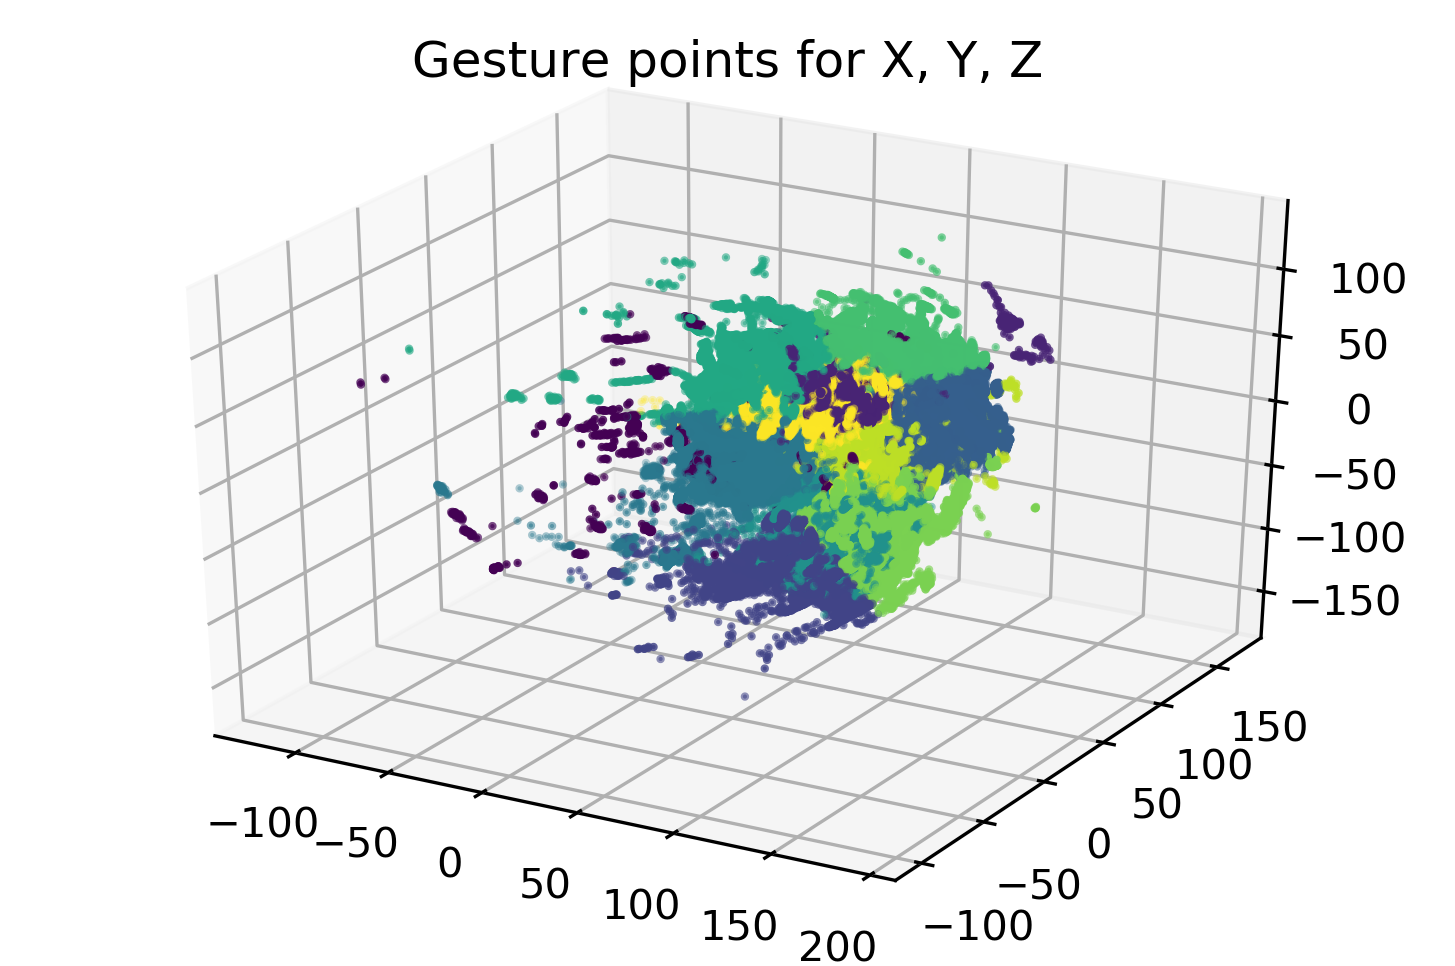

In [22]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = kms_X['Z'].astype(float)
xdata = kms_X['X'].astype(float)
ydata = kms_X['Y'].astype(float)
ax.scatter3D(kms_X['X'], kms_X['Y'], kms_X['Z'], c=kms_clusters, s=1)
ax.set_title('Gesture points for X, Y, Z')

In [23]:
plot_3d(allpts=True, clusters=kms_clusters)

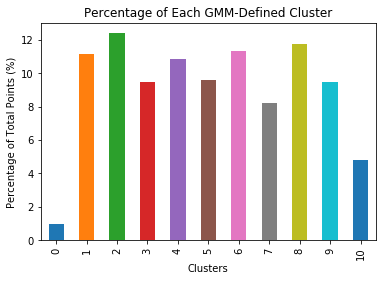

In [24]:
# Create a new dataframe with the clusters defined as a new variable
df_kms = kms_X.copy()
df_kms['Clusters'] = kms_clusters

# Count the number of instances in each cluster and convert to a percentage of the total
cluster_pcts = df_kms.groupby('Clusters').count()['X'] / len(df_kms) * 100

# Plot the distribution
ax = cluster_pcts.plot(kind='bar', title="Percentage of Each GMM-Defined Cluster")
_ = ax.set_ylabel("Percentage of Total Points (%)")

### Modeling and Evaluation 2
#### 10pts
Evaluate and Compare

##### https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

In [25]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


# Split into X Features & Y Training
df2b = df2.copy()
df2b = df2b[df2b.User > 12 ] #User 13 & 14
df3 = df2b[['X','Y','Z']]
X = df3.values[:,]
df3s = df2b[['Sensor']]
y = df3s.values[:,] 
 

# Not done for now
range_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=11, init='k-means++',random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

#plt.show()

Automatically created module for IPython interactive environment


### Modeling and Evaluation 3
#### 10 pts
Visualize Results

### Modeling and Evaluation 4
#### 20 pts
Summarize the Ramifications

### Deployment 
#### 10 pts
Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

### Exceptional Work
#### 10 pts
You have free reign to provide additional analyses or combine analyses.

### Attempt to Center Data

The data in this dataset is taken with slightly differing points serving as the origin for each coordinate set. Due to this fact, we attempted to center our data somewhat by subtracting the minimum value for each coordinate set corresponding to a given capture. We had hoped that this would allow us to reduce variance and keep points on a more even plane. Unfortunately, the centering method was not successful and we ended up with a lower silhouette score than was obtained otherwise. Nevertheless, we believe that it was incredibly important to the data cleaning process to rule out any potential for improving our dataset prior to clustering, and this method allowed us to rule out one potential change that could have been made to the dataset.

##### Chris please change as much as you want, just wanted to get somethind down so we have a good argument for why we should get exceptional work points

### Data centering
this section searches for minimum x,y,z coordinate values and zeroes them and adjusts each coordinate accordingly to reduce variation relative to starting hand position

In [26]:
#creates new sub dataframes for x y and z coordinates
dfx=df[['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']].copy()
dfy=df[['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']].copy()
dfz=df[['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']].copy()

In [27]:
#calculates min value
dfx['xmin']=dfx.min(axis=1)
dfy['ymin']=dfy.min(axis=1)
dfz['zmin']=dfz.min(axis=1)

In [28]:
###takes minimum and subtracts form all
for a in range(11): 
    dfx['X%d' % a] = dfx['X%d' % a] - dfx['xmin']
    
for b in range(11): 
    dfy['Y%d' % b] = dfy['Y%d' % b] - dfy['ymin']
    
for c in range(11): 
    dfz['Z%d' % c] = dfz['Z%d' % c] - dfz['zmin']    

In [29]:
#remove the calculated min values for merging
del dfx['xmin']
del dfy['ymin']
del dfz['zmin']

In [30]:
#create mini dataframe and then concatenate the transformed dataframes
dfmini = df.iloc[:,0:2].copy()
dfnew= pd.concat([dfmini,dfx, dfy,dfz], axis=1)

In [31]:
#reorder the columns
dfnew = dfnew[['Class','User', 'X0','Y0','Z0','X1','Y1','Z1','X2','Y2','Z2','X3','Y3','Z3','X4','Y4','Z4','X5','Y5','Z5',
               'X6','Y6','Z6','X7','Y7','Z7','X8','Y8','Z8','X9','Y9','Z9','X10','Y10','Z10']]

In [32]:
dfnew.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
1,1,0,17.642651,60.787840,8.876421,40.274406,31.783563,0.903585,0.000000,71.001621,20.764858,48.611035,57.070283,0.000000,22.567347,0.000000,2.386349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,17.391580,60.486690,8.768739,0.000000,70.758611,21.107482,40.087765,31.474172,0.721502,48.314895,56.620889,0.000000,22.451473,0.000000,1.876573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,17.861124,60.675624,8.575556,0.000000,70.837907,20.532085,40.462722,31.773963,0.479855,48.846584,57.114485,0.000000,23.697623,0.000000,2.249028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,18.767785,60.456627,8.539505,0.000000,70.618101,19.475677,49.758767,56.963997,0.000000,25.034295,0.000000,3.272036,40.825363,31.467185,0.213315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,18.966583,60.594498,8.397440,0.000000,70.715764,19.098996,40.810326,31.585739,0.000000,50.192930,57.060151,0.130093,25.099584,0.000000,3.294837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#1=Fist(with thumb out), 
#2=Stop(hand flat), 
#3=Point1(point with pointer finger), 
#4=Point2(point with pointer and middle fingers), 
#5=Grab(fingers curled as if to grab). 

#filter certain users for plotting below
df_user6 = df[df.User == 6][df.Class == 2]
df_user14 = df[df.User == 14][df.Class == 1]
df_user5 = df[df.User == 5][df.Class == 4]
df_user8 = df[df.User == 8][df.Class == 3]

#One row in data table - represnts on set of data points
df_row12000 = df[11999:12000][df.Class == 5]

# feature categories
X_features = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
Y_features = ['Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Y10']
Z_features = ['Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10']

##### One record plotted in 3D show Class 5 (Grab Gestures)

In [ ]:
#one set of markers
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_row12000[Z_features].astype(float)
xdata = df_row12000[X_features].astype(float)
ydata = df_row12000[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 6's records plotted in 3D with Posture 3 (Stop sign)

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user6[Z_features].astype(float)
xdata = df_user6[X_features].astype(float)
ydata = df_user6[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 14's records plotted in 3D with Class 1 (Fist Gesture)

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user14[Z_features].astype(float)
xdata = df_user14[X_features].astype(float)
ydata = df_user14[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 8's records plotted in 3D with Class 3 (point with pointer finger Gesture)

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user8[Z_features].astype(float)
xdata = df_user8[X_features].astype(float)
ydata = df_user8[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D with Class 5 (Grab Gesture)

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = df_user5[Z_features].astype(float)
xdata = df_user5[X_features].astype(float)
ydata = df_user5[Y_features].astype(float)
ax.scatter3D(xdata, ydata, zdata);

##### All User 5's records plotted in 3D in a Wireframe show Class 2 (Stop Gesture)

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(df_user6[X_features], df_user6[Y_features], df_user6[Z_features], color='black')
ax.set_title('wireframe');
